In [1]:
import pandas as pd 
import numpy as np
import funciones as fs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

PROCEDEMOS A GENERAR EL DATAFRAME PARA EMPEZAR CON LA LIMPIEZA. 

In [2]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


ANALIZAMOS LA COMPOSICIÓN DE LOS DATOS

In [3]:
fs.dataset_overview(df)

Shape
Rows: 45211 | Columns: 17
Data Types
object    10
int64      7
Name: count, dtype: int64
Missing Values
No missing values


In [4]:
fs.col_numericas(df)


,count,mean,std,min,25%,50%,75%,max,skew
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0,0.684818
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0,8.360308
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0,0.093079
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0,3.144318
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0,4.898650
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0,2.615715
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0,41.846454


DE ACUERDO A LOS COMENTARIOS DEL DATASET, PROCEDEREMOS A ELIMINAR LA COLUMNA DURACION YA QUE NO NOS SERVIRA PARA DESARROLLAR UN MODELO PREDICTIVO. 

In [5]:
columns_drop = ["duration"]

In [6]:
fs.drop_columns(df, columns_drop)

CREAMOS UNA LISTA DE LAS COLUMNAS NUMERICAS

In [7]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [8]:
fs.col_categoricas(df)

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


CREAMOS UNA LISTA DE LAS COLUMNAS CATEGORICAS

In [9]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')

PROCEDEMOS A VERIFICAR LA PROPORCIÓN DE LA COLUMNA "Y" PARA EVALUAR EL ESCENARIO.

In [10]:
df["y"].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

<Axes: xlabel='y'>

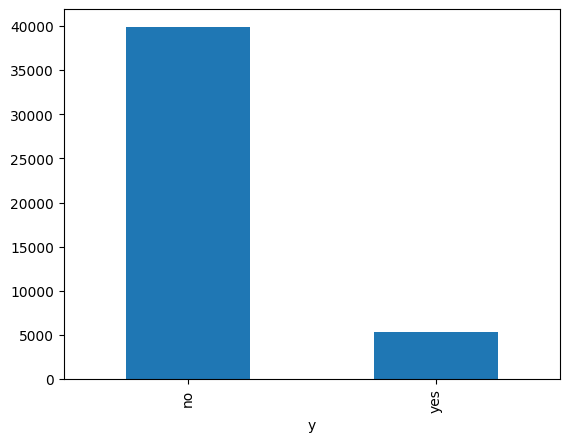

In [21]:
df['y'].value_counts().plot(kind='bar')

VERIFICAMOS QUE HAY UN DESBALANCE SIGNIFICATIVO DE LOS "NO" LO CUAL NOS HARA TOMAR ATENCION A LAS METRICIAS SELECCIONADAS A LA HORA DE REALIZAR EL MODELO PREDICTIVO. 

UNA VEZ QUE TENEMOS LA INFORMACIÓN GENERAL DEL DATASET AVANZAMOS EN NUESTRO ANALISIS. LO PRIMERO QUE HAREMOS ES VER LA RELACION ENTRE CLIENTES QUE DAN EL "SI" PARA ABRIR UN DEPOSITO Y LAS COLUMNAS NUMERICAS.

In [13]:
df.groupby("y")[numerical_columns].mean()

,age,balance,day,campaign,pdays,previous
y,,,,,,
no,40.838986,1303.714969,15.892290,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,2.141047,68.702968,1.170354


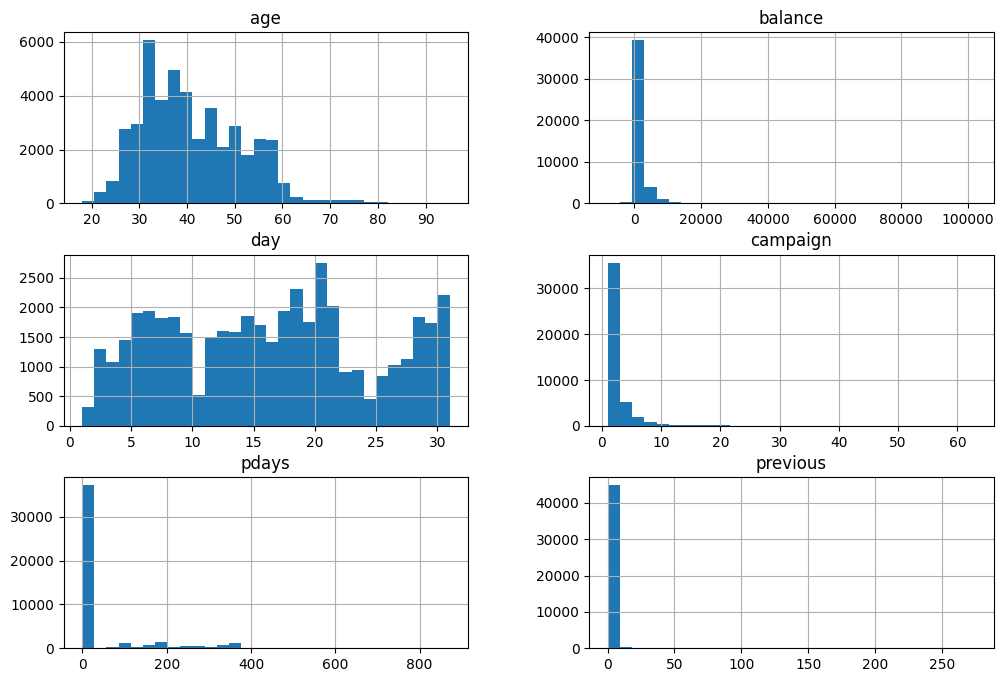

In [14]:
df[numerical_columns].hist(figsize=(12,8), bins=30)
plt.show()

De estos histogramas podemos sacar las siguientes observaciones: 
 - El balance tiene una clara acumulación entre los 1k y 25k
 - La mayoria de los clientes, segun "campaign", tienen entre 3 y 5 llamadas. 
 - Hay una cola extendida en el grafico pdays lo que sugiere que se los llama dentro de un año calendario a cada cliente. 
 - Por lo menos se llamo una vez al cliente antes de esta campaña de marketing. 

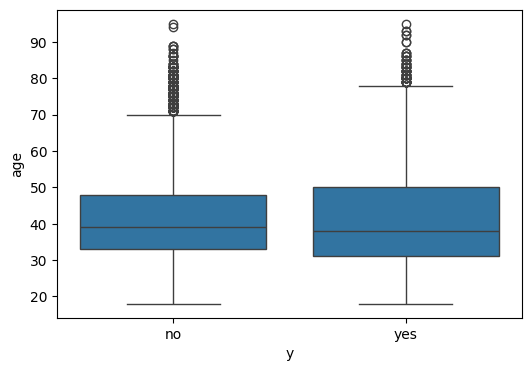

In [25]:
plt.figure(figsize=(6,4))
sns.boxplot(x='y', y='age', data=df)
plt.show()

LA MEDIA DE EDAD DE LOS CLIENTES SI Y NO ES PRACTICAMENTE IGUAL PERO EL "NO" TIENE MUCHOS OUTLIERS. 